For designing the models I split the training dataset into 50,000 samples of data for training and 10,000 for validation. All accuracy values here are based on the validation part, except for the final model.

At the end of the design phase I also began experimenting with data augmentation - horizontal flips (which I have been considering not to use on shoes for example after examining the dataset - they seem to be always only in one direction, but I have not tried it in the end) and various forms of simple data normalization.

I started with a very basic model in order to have some baseline and seeing how the training goes. It reached 90% accuracy - pretty promissing for just a 5C3-2P2-64-10, given that the highest accuracy I got using deep, dense models was 89% (using whole training set for training and the test set for validation).

The training was taking just a moment so I was experimenting with hyperparameters of the basic model - number of filters, padding, kernel size, etc. Then I made the models deeper and was trying to get a 'feel' for their behaviour. I wanted to see how LeNet-5 would perform on this dataset - I found out it virtually could not get over 90% accuracy, I looked up for a different LeNet model, I coppied one from [this article](https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/) it was reaching 91.5%.

I found out that narrowing the model too much by doing many convolutions without padding hungers the model of parameters and renders it underfitting - it seems that models with less then 100,000 weights were hungry and could not get above 93% accuracy.

The other problem was trying to tame the overfitting models, of course, I was thinking about regularization but I had wasn't sure whether it is a good idea (as there are not so many parameters and the filters work differently than dense layers), I tried a couple of examples and I would say it was inconslusive - sometimes very good results, sometimes severe underfitting (especially with L2 weight regularization)...  I came across [this](https://arxiv.org/pdf/1512.01400.pdf) paper which gave me some direction where to apply dropout layers and what does it represent. The technique of putting a dropout layer before max-pooling increased the accuracy of, for example, the LeNet model in previous paragraph to 92.5% without tuning. I also tried putting a dropout layer on the very input layer, in faith that it would do some sort of data diversification/augmentation, however if there were already other regularizers introduced, the effect was a considerably slower learning rate and not much benefit in terms of accuracy.

In the end I iterated through to models which were reaching almost 94% accuracy without regularization (particulary one containing about 0.62M parameters and another having about 0.23M), I decided to fine-tune and train using augmented data the bigger model. Its final accuracy is {}% which puts it on a surprisingly good place among the submitted benchmarks in [Fashion-MNIST's GitHub repo](https://github.com/zalandoresearch/fashion-mnist).

I have been pondering what results would the following process bring: 
1. training model with little or no hidden dense layers, several convolutional and pooling layers
2. disabling training on these layers afterwards
3. replacing the output layer with a submodel of dense layers
4. training the model again (the added layers)

I suspect, this way better filters or something interesting might happen, unfortunatelly, I did not know how to achieve this simply...


In [1]:
# for switching between GPU and CPU
NO_GPU = False

if NO_GPU:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as kl
from keras.preprocessing.image import ImageDataGenerator

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_model(*layers, verbose=False,
               optimizer='adam', loss='categorical_crossentropy', metrics=['acc'],
               compile_kwargs={}):
    
    model = keras.models.Sequential()
    
    for layer in layers:
        model.add(layer)
        
    if verbose:
        print("Model summary:")
        model.summary()
    
    for kw in ('optimizer', 'loss', 'metrics'):
        if not kw in compile_kwargs:
            compile_kwargs[kw] = locals()[kw]
    model.compile(**compile_kwargs)
    
    return model

In [3]:
def plot_history(history, figsize=(15,4), title='', columns=2, start_x_from=0):
    """Graphs a history for each key (combines validation and training keys into one plot).
    
    start_x_from=N skips the first N entries.
    
    History can be a whole training history class or just a dict."""
    
    if hasattr(history, 'history'): # full history given
        history = history.history   # only that history is enough
        
    assert hasattr(history, 'keys')
    keys = [key for key in history.keys() if not key.startswith("val_")]
    assert keys # there is one at least
    epochs = list(range(1,len(history[keys[0]])+1)) # all should have the same size list
    
    rows = np.ceil(len(keys)/columns).astype('int')
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    i = 1
    for key in sorted(keys):
        valkey = "val_" + key
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.plot(epochs[start_x_from:], history[key][start_x_from:], label="Training " + key,
                 marker='.', color='#00A287', linestyle='')
        
        late_avg = np.mean(history[key][(len(history[key]) * 90) // 100 : ])
        plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                 color="#74E600", label='Mean {:.3f}'.format(late_avg))
        if valkey in history:
            plt.plot(epochs[start_x_from:], history[valkey][start_x_from:], label='Validation ' + key,
                    marker='+', color='#DF004F', linestyle='')
            
            late_avg = np.mean(history[valkey][(len(history[valkey]) * 90) // 100 : ])
            plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                     color="#FF6700", label='Mean {:.3f}'.format(late_avg))
        plt.legend()
        
    plt.show()

In [4]:
def all_same_length(*args):
    """Returns True if all arguments have equal len(.)"""
    return all(len(a) == len(args[0]) for a in args)

def shuffle_together(*numpy_arrays):
    """Shuffles numpy arrays in unison, returns a tuple.
    
    (applies the same random permutation to all of them,
    so they have to be the same length on axis=0)"""
    
    assert all_same_length(*numpy_arrays)
    permut = np.random.permutation(len(numpy_arrays[0]))
    return tuple(a[permut] for a in numpy_arrays)

In [5]:
### Import the dataset & apply transformations

(x_train_orig, y_train_orig), (x_test, y_test) = keras.datasets\
                                        .fashion_mnist.load_data()

y_train_orig = keras.utils.to_categorical(y_train_orig)
y_test = keras.utils.to_categorical(y_test)

x_train_orig = x_train_orig.reshape(*x_train_orig.shape, 1).astype('float32') / 255.0
x_test = x_test.reshape(*x_test.shape, 1).astype('float32') / 255.0

SPLIT = 10000
x_valid = x_train_orig[:SPLIT]
y_valid = y_train_orig[:SPLIT]

x_train = x_train_orig[SPLIT:]
y_train = y_train_orig[SPLIT:]

INPUT_SHAPE = x_train[0].shape
VERBOSE=False
FIT_SETS = dict(x=x_train, y=y_train, validation_data=(x_valid, y_valid))
STATS_STR = ('Last epoch {epoch:}\t|'     '  Training  |'          '  Validation  |{nl:}'  
             'Loss \t\t|'          '  {loss[0]: 8.4f}  |''  {val_loss[0]: 10.4f}  |{nl:}'
             'Acc  \t\t|'           '  {acc[0]: 8.4f}  |' '  {val_acc[0]: 10.4f}  |')
BS = 500
EPOCHS=50
GEN_KWARGS = {} #dict(samplewise_center=True, samplewise_std_normalization=True)

train_gen = ImageDataGenerator(**GEN_KWARGS, horizontal_flip=True)
train_data_flow = train_gen.flow(x_train_orig, y_train_orig, batch_size=BS)

test_gen = ImageDataGenerator(**GEN_KWARGS)
test_data_flow = test_gen.flow(x_test, y_test, batch_size=BS)

In [6]:
# baseline (validation accuracy about 0.90)
# its siblings were reaching accuracy up to 0.92 (and blazingly fast to train)
model_simple = build_model(
    kl.InputLayer(INPUT_SHAPE),
    
    kl.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    kl.MaxPool2D(pool_size=2, strides=2),
    
    kl.Flatten(),
    
    kl.Dense(units=64, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_simple = model_simple.fit(**FIT_SETS, epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                100416    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 101,146
Trainable params: 101,146
Non-tr

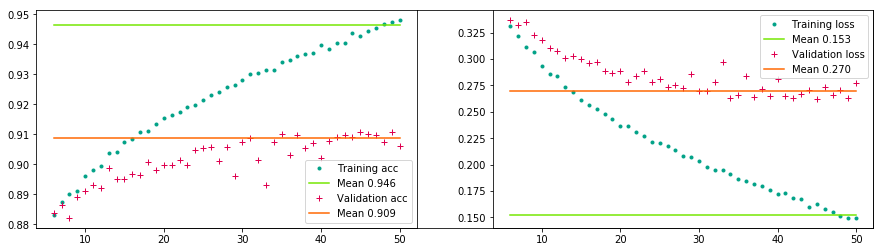

In [7]:
plot_history(hist_simple, start_x_from=5)

In [8]:
# LeNet-5 (accuracy up to 0.90)
model_lenet5 = build_model(
    kl.InputLayer(INPUT_SHAPE),
    
    kl.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same'),
    kl.MaxPool2D(pool_size=2, strides=2),
    
    kl.Conv2D(filters=16, kernel_size=5, activation='relu', padding='valid'),
    kl.MaxPool2D(pool_size=2, strides=2),
    
    kl.Flatten(),
    
    kl.Dense(units=120, activation='relu'),
    kl.Dense(units=84, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_lenet5 = model_lenet5.fit(**FIT_SETS, epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               48120 

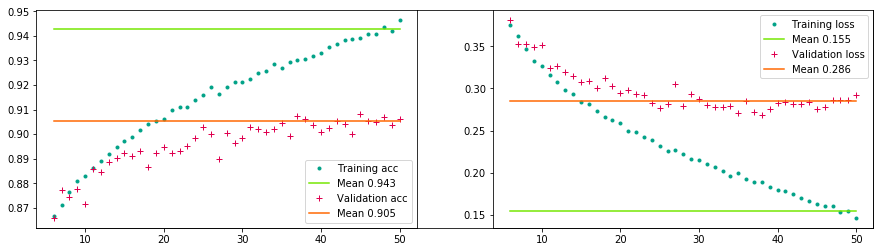

In [9]:
plot_history(hist_lenet5, start_x_from=5)

In [10]:
# quite poor just about 0.915
# LeNet
# https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/
model_lenet = build_model(
    kl.InputLayer(INPUT_SHAPE),

    kl.Conv2D(filters=20, kernel_size=5, padding='same', activation='relu'),
    kl.MaxPool2D(pool_size=2, strides=2),


    kl.Conv2D(filters=50, kernel_size=5, padding='same', activation='relu'),
    kl.MaxPool2D(pool_size=2, strides=2),

    kl.Flatten(),

    kl.Dense(units=500, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_lenet = model_lenet.fit(**FIT_SETS, epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               122550

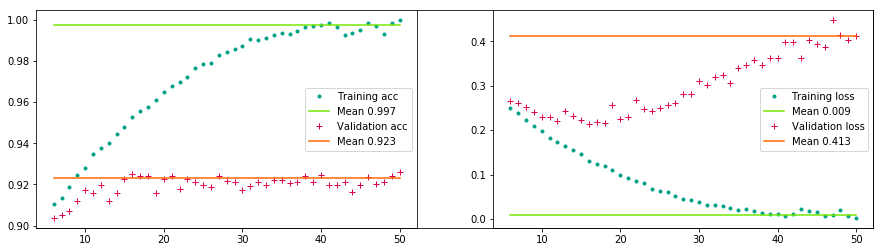

In [11]:
plot_history(hist_lenet, start_x_from=5)

In [12]:
# quite poor just about 0.915
# LeNet
# https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/
model_lenet_reg = build_model(
    kl.InputLayer(INPUT_SHAPE),

    kl.Conv2D(filters=20, kernel_size=5, padding='same', activation='relu'),
    kl.Dropout(0.3),
    kl.MaxPool2D(pool_size=2, strides=2),


    kl.Conv2D(filters=50, kernel_size=5, padding='same', activation='relu'),
    kl.Dropout(0.3),
    kl.MaxPool2D(pool_size=2, strides=2),

    kl.Flatten(),

    kl.Dropout(0.3),
    kl.Dense(units=500, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_lenet_reg = model_lenet_reg.fit(**FIT_SETS, epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 50)          0     

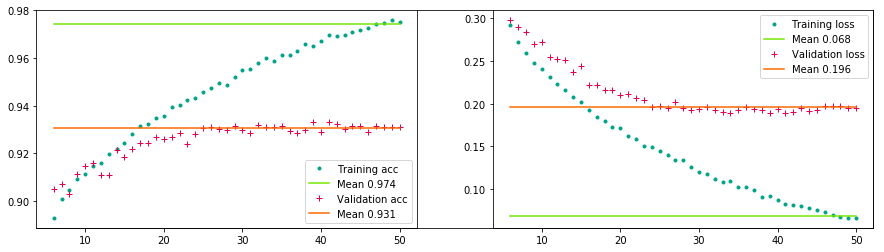

In [13]:
plot_history(hist_lenet_reg, start_x_from=5)

In [14]:
# quite complex, but starving model (0.91)
model_starving = build_model(
    kl.InputLayer(INPUT_SHAPE),
    
    kl.Conv2D(filters=20, kernel_size=5, padding='same', activation='relu'),
    kl.Conv2D(filters=30, kernel_size=5, padding='same', activation='relu'),
    kl.MaxPool2D(pool_size=2, strides=2),

    kl.Conv2D(filters=20, kernel_size=5, padding='same', activation='relu'),
    kl.Conv2D(filters=30, kernel_size=3, activation='relu'),
    kl.MaxPool2D(pool_size=2, strides=2),

    kl.Conv2D(filters=20, kernel_size=3, padding='same', activation='relu'),
    kl.Conv2D(filters=20, kernel_size=3, activation='relu'),
    kl.MaxPool2D(pool_size=2, strides=2),

    kl.Flatten(),

    kl.Dense(units=80, activation='relu'),
    kl.Dense(units=80, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_starving = model_starving.fit(**FIT_SETS, epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 30)        15030     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 20)        15020     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 30)        5430      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 30)          0     

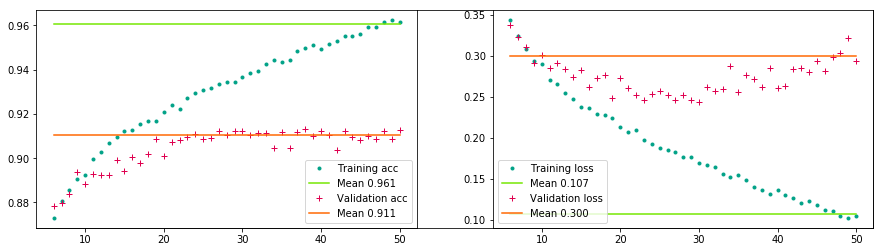

In [15]:
plot_history(hist_starving, start_x_from=5)

In [16]:
# the final model
model_final = build_model(
    kl.InputLayer(INPUT_SHAPE),

    kl.Conv2D(filters=20, kernel_size=3, activation='relu', padding='same' ),
    kl.Conv2D(filters=40, kernel_size=3, activation='relu', padding='same' ),
    kl.Dropout(0.2),
    kl.MaxPool2D(),

    kl.Conv2D(filters=40, kernel_size=3, activation='relu', padding='same' ),
    kl.Dropout(0.2),
    kl.MaxPool2D(strides=1),

    kl.Conv2D(filters=40, kernel_size=3, activation='relu', padding='same' ),
    kl.Dropout(0.2),
    kl.MaxPool2D(strides=1),

    kl.Flatten(),

    kl.Dropout(0.35),
    kl.Dense(units=130, activation='relu'),
    kl.Dropout(0.5),
    kl.Dense(units=105, activation='relu'),
    kl.Dropout(0.4),
    kl.Dense(units=10, activation='softmax'),

    verbose=1
)

epoch = 0
history = {k:[] for k in ['val_loss', 'val_acc', 'loss', 'acc']}

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 20)        200       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 40)        7240      
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 40)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 40)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 40)        14440     
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 40)        0     

In [18]:
while epoch < 900:
    last_history = model_final.fit_generator(generator=train_data_flow,
                                    validation_data=test_data_flow,
                                    steps_per_epoch=len(x_train_orig) // BS,
                                    epochs=epoch+1, initial_epoch=epoch,
                                    verbose=0)
    
    for k, v in last_history.history.items():
        history[k].append(v[0])
        
    print(STATS_STR.format(nl=' '*100, epoch=epoch, **last_history.history), end='\r')
    epoch += 1

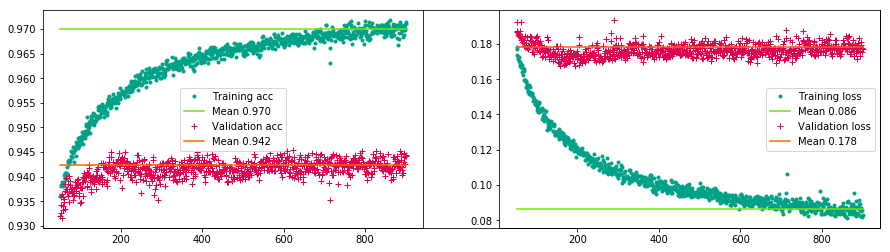

In [19]:
plot_history(history, start_x_from=50)